## Data


**train.csv:** 
  1. building_id - Foreign key for the building metadata.
  2. meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
  2. timestamp - When the measurement was taken
meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.
  3. site_id - Foreign key for the weather files.
  4. building_id - Foreign key for training.csv
  5. primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
  6. square_feet - Gross floor area of the building
  7. year_built - Year building was opened
  8. floor_count - Number of floors of the building


**weather_[train/test].csv**: Weather data from a meteorological station as close as possible to the site.

  1. site_id
  2. air_temperature - Degrees Celsius
  3. cloud_coverage - Portion of the sky covered in clouds, in oktas
  4. dew_temperature - Degrees Celsius
  5. precip_depth_1_hr - Millimeters
  6. sea_level_pressure - Millibar/hectopascals
  7. wind_direction - Compass direction (0-360)
  8. wind_speed - Meters per second

**test.csv**: The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

  1. row_id - Row id for your submission file
  2. building_id - Building id code
  3. meter - The meter id code
  4. timestamp - Timestamps for the test data period
  
**sample_submission.csv**: A valid sample submission. 
  1. All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.

  2. There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

# Performance Metric

the evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

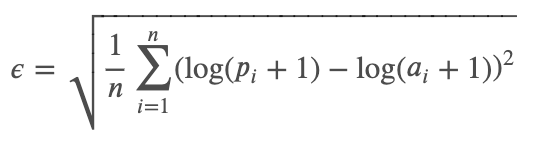

## Importing necessary libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


## Loading the ASHRAE dataset

In [11]:
data_path = "/kaggle/input/ashrae-energy-prediction/"

train_path = data_path + "train.csv"
test_path = data_path + "test.csv"

building_path = data_path + "building_metadata.csv"

weather_train_path = data_path + "weather_train.csv"
weather_test_path = data_path + "weather_test.csv"

In [12]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


building_data = pd.read_csv(building_path)

weather_train_data = pd.read_csv(weather_train_path)
weather_test_data = pd.read_csv(weather_test_path)

In [36]:

train_data = train_data.loc[train_data['meter'] == 0]
train_data=train_data.reset_index()


## Viewing Snippets of the dataset

In [37]:
train_data.head()

,level_0,index,building_id,meter,timestamp,meter_reading
0,0,0,0,0,2016-01-01 00:00:00,0.0
1,1,1,1,0,2016-01-01 00:00:00,0.0
2,2,2,2,0,2016-01-01 00:00:00,0.0
3,3,3,3,0,2016-01-01 00:00:00,0.0
4,4,4,4,0,2016-01-01 00:00:00,0.0


In [38]:
train_data.describe()

,level_0,index,building_id,meter,meter_reading
count,1.206091e+07,1.206091e+07,1.206091e+07,12060910.0,1.206091e+07
mean,6.030454e+06,1.006377e+07,7.066480e+02,0.0,1.708256e+02
std,3.481685e+06,5.847051e+06,4.152330e+02,0.0,3.808343e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
25%,3.015227e+06,4.964611e+06,3.450000e+02,0.0,1.950000e+01
50%,6.030454e+06,1.004999e+07,6.980000e+02,0.0,6.283190e+01
75%,9.045682e+06,1.512978e+07,1.063000e+03,0.0,1.700750e+02
max,1.206091e+07,2.021610e+07,1.448000e+03,0.0,7.976900e+04


In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12060910 entries, 0 to 12060909
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   level_0        int64  
 1   index          int64  
 2   building_id    int64  
 3   meter          int64  
 4   timestamp      object 
 5   meter_reading  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 552.1+ MB


In [40]:
test_data.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [41]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [42]:
weather_train_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [43]:
weather_test_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [44]:
print('Shape of Train Data:',train_data.shape)
print('Shape of Test Data:', test_data.shape)
print('Shape of Building Data:', building_data.shape)
print('Shape of Weather Train Data:', weather_train_data.shape)
print('Shape of Weather Test Data:', weather_test_data.shape)

Shape of Train Data: (12060910, 6)
Shape of Test Data: (41697600, 4)
Shape of Building Data: (1449, 6)
Shape of Weather Train Data: (139773, 9)
Shape of Weather Test Data: (277243, 9)


## Converting data to feather format for faster loading

In [45]:
train_data.to_feather('train_data.feather')
test_data.to_feather('test_data.feather')

building_data.to_feather('building_data.feather')

weather_train_data.to_feather('weather_train_data.feather')
weather_test_data.to_feather('weather_test_data.feather')


In [46]:
train_data = pd.read_feather('train_data.feather')
test_data = pd.read_feather('test_data.feather')

building_data = pd.read_feather('building_data.feather')

weather_train_data = pd.read_feather('weather_train_data.feather')
weather_test_data = pd.read_feather('weather_test_data.feather')


## Reducing the memory usage of the data

In [47]:
def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df


In [48]:
train_data = reduce_mem_usage(train_data, 'Train Data')
test_data = reduce_mem_usage(test_data, 'Test Data')

building_data = reduce_mem_usage(building_data, 'Building Data')

weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')
weather_test_data = reduce_mem_usage(weather_test_data, 'Weather Test Data')

Memory usage of Train Data is reduced by 64.53 %. Usage dropped from 552.10 MB to 195.86 MB.
Memory usage of Test Data is reduced by 71.82 %. Usage dropped from 1272.51 MB to 358.53 MB.
Memory usage of Building Data is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather Train Data is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.
Memory usage of Weather Test Data is reduced by 73.04 %. Usage dropped from 19.04 MB to 5.13 MB.


## Merging Data

In [49]:
train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [50]:
test = test_data.merge(building_data, on='building_id', how='left')
test = test.merge(weather_test_data, on=['site_id', 'timestamp'], how='left')

In [51]:
train.head()

,level_0,index,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [52]:
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [53]:
print('Shape of Combined Train Data:',train.shape)
print('Shape of Combined Test Data:', test.shape)

Shape of Combined Train Data: (12060910, 18)
Shape of Combined Test Data: (41697600, 16)


## Breaking Timestamp into Hour, Day, Month, Year

In [54]:
# convert timestamp to date and then breaks down date into 6 new columns: hour, day, dayOfWeek, dayOfYear, month and year

def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [55]:
train = breakdown_timestamp(train)
test = breakdown_timestamp(test)

In [56]:
print('New Shape of Train Data:',train.shape)
print('New Shape of Test Data:', test.shape)

New Shape of Train Data: (12060910, 24)
New Shape of Test Data: (41697600, 22)


## Exploring the Target Value 'Meter Reading'

In [57]:
# This Function Draws the distribution plot for the column passed into the function's arguments

sns.set_theme()

def draw_distribution_graph(dataframe, column_name):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(dataframe[column_name], color='purple', ax = ax).set_title("Distribution Graph for {}".format(column_name), fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.show()

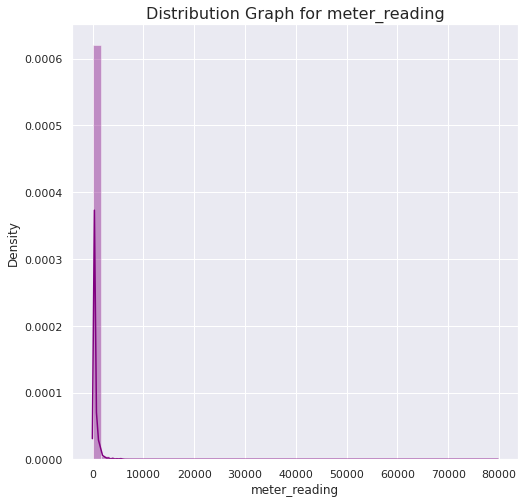

In [58]:
draw_distribution_graph(train, 'meter_reading')

In [59]:
print('Meter Reading has a skewness of', train['meter_reading'].skew())

Meter Reading has a skewness of 9.96099


1. The Meter Reading is skewed to the left.
2. We need to apply log tranformation to fix the skewness.


In [60]:
train['meter_reading']=np.log1p(train['meter_reading'])

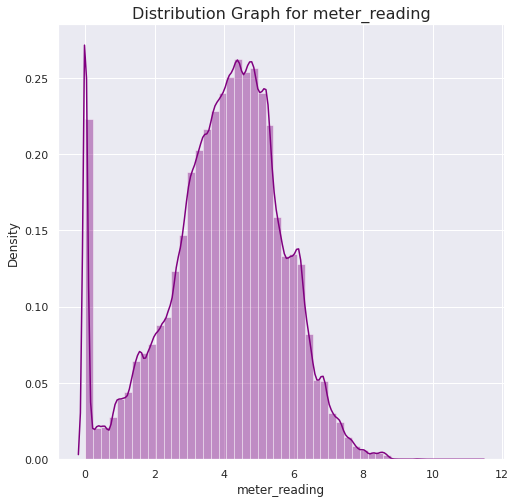

In [61]:
draw_distribution_graph(train, 'meter_reading')

In [62]:
print('Meter Reading has a new skewness of', train['meter_reading'].skew())

Meter Reading has a new skewness of -0.4543164


- The most recurrent meter reading is zero. (This will be taken care of in the data preperation section)


## Exploring Frequency of the Different Primary Use Categories 

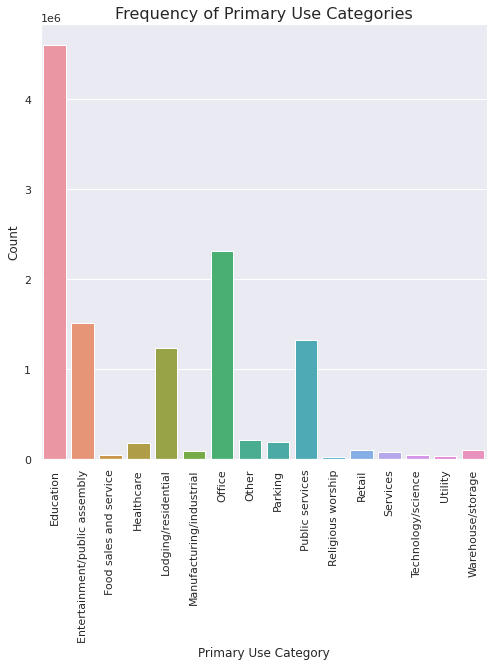

In [63]:
plt.figure(figsize=(8,8))
sns.countplot(x = 'primary_use', data = train).set_title("Frequency of Primary Use Categories", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Primary Use Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

1. Educational buildings contribute the largest number of readings. 
2. Religious worships contribute the least readings.

## Exploring Average Meter Reading Per Site and Use Category

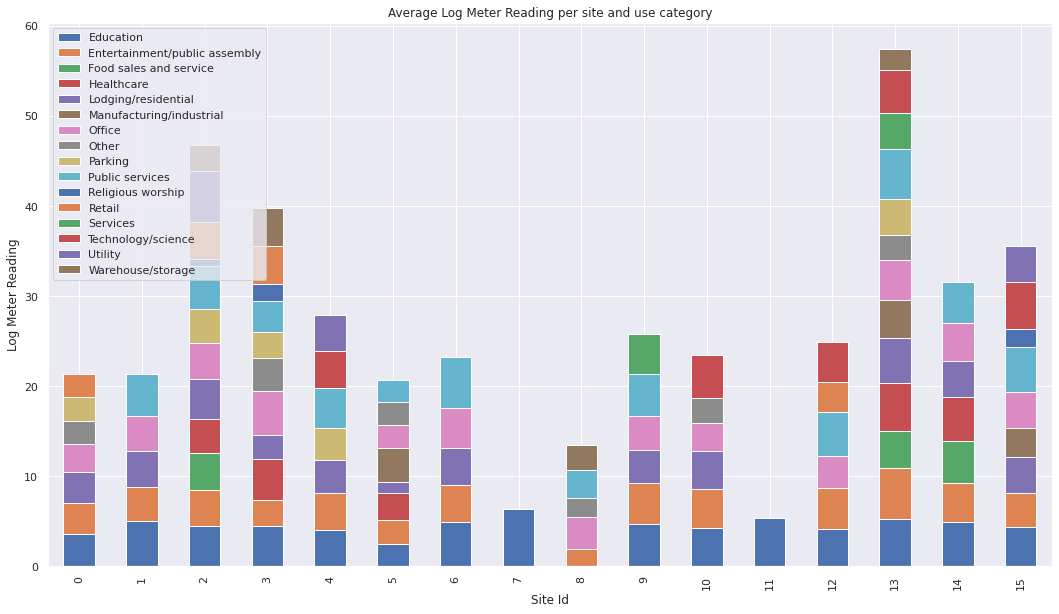

In [64]:
site_use_grouping = train.groupby(['site_id','primary_use'])['meter_reading'].mean().unstack('primary_use')
site_use_grouping.plot(kind = 'bar', stacked = True, figsize=(18,10)).set_title("Average Log Meter Reading per site and use category")
plt.xlabel('Site Id')
plt.ylabel('Log Meter Reading')
plt.legend(loc = "upper left")
plt.show()

1. Site 13 has the highest average meter readings.
2. Site 11 has the least average meter readings and buildings in this site are primarily used as educational institutions.

## Exploring Average Readings per Hour and Month

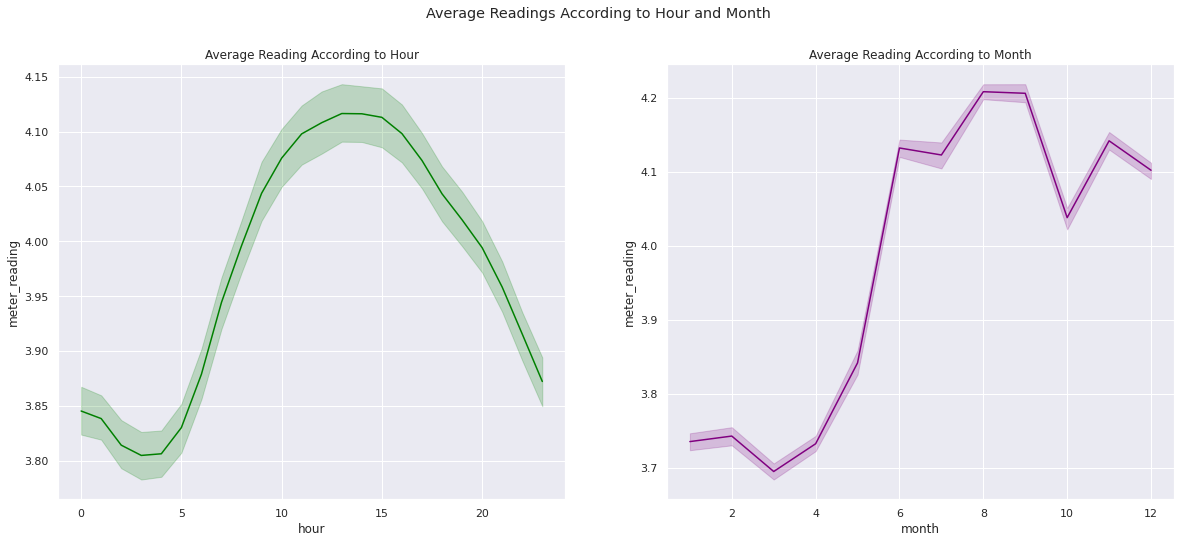

In [65]:
hour_groups = train.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
month_groups = train.groupby(['timestamp','month']).meter_reading.mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Average Readings According to Hour and Month')

sns.lineplot(x = hour_groups['hour'], y = hour_groups['meter_reading'], color='green', ax = ax1)
ax1.set_title('Average Reading According to Hour')


sns.lineplot(x = month_groups['month'], y = month_groups['meter_reading'], color='purple', ax = ax2)
ax2.set_title('Average Reading According to Month')

plt.show()

1. Energy consumption drops in the early hours of the morning around 3-4am and rises again after 5am.
2. The hourly usage is maximized in the duration of 12-3pm, peeking at 1 in the afternoon Which is a logical conclusion as many instituitions work around this period.
3. Energy Consumption is minimal during the period of January to March, reaching its lowest in March.
4. Consumption starts rising gradually from April and reaches a peek in August.


## Exploring Average Readings per Building

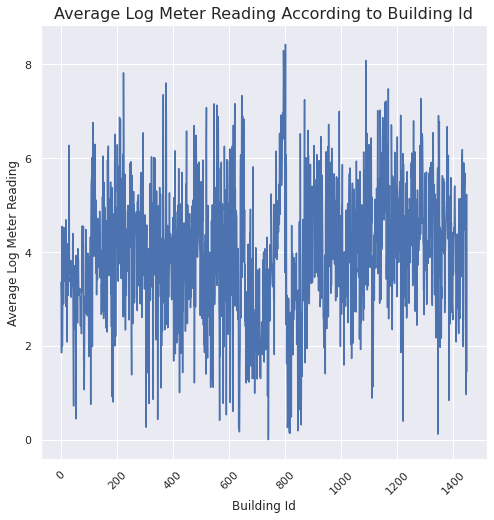

In [66]:
building_groups = train.groupby(['building_id']).meter_reading.mean().reset_index()

plt.figure(figsize=(8,8))
sns.lineplot(x = building_groups['building_id'], y = building_groups.meter_reading).set_title("Average Log Meter Reading According to Building Id", fontsize=16)
plt.xlabel('Building Id', fontsize=12)
plt.ylabel('Average Log Meter Reading', fontsize=12)
plt.xticks(rotation=45)
plt.show()

##  Checking Missing Values

In [67]:
missing_values = pd.DataFrame(train.isnull().sum() * 100 / len(train))
missing_values.columns = ["Missing Values"]

missing_values = missing_values[missing_values["Missing Values"] != 0]
missing_values.sort_values(by = "Missing Values", axis = 0, ascending = False, inplace = True)

missing_values

,Missing Values
floor_count,75.417883
year_built,53.644667
cloud_coverage,44.189468
precip_depth_1_hr,20.841537
sea_level_pressure,8.443666
wind_direction,5.627395
wind_speed,0.553814
dew_temperature,0.407026
air_temperature,0.392383


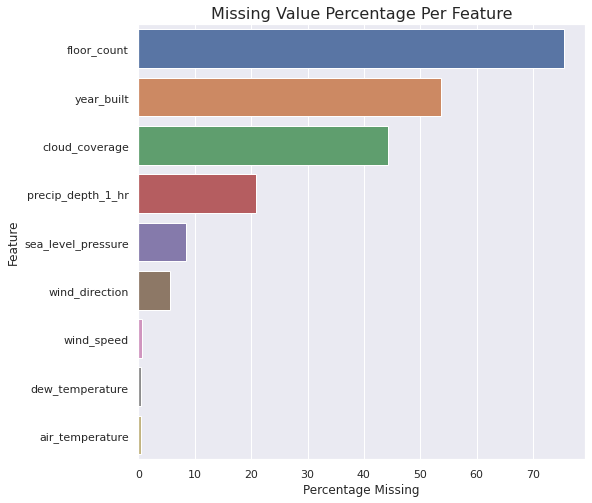

In [68]:
plt.figure(figsize=(8,8))
sns.barplot(x = missing_values['Missing Values'], y = missing_values.index).set_title("Missing Value Percentage Per Feature", fontsize=16)
plt.xlabel('Percentage Missing', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

1. Floor count has the highest number of missing values.
2. Year Built is the second leading column in missing values with almost 55% of the data being null.
3. This needs to be taken care of during the data preparation process before feeding it to the models for training.

## Visualizing Correlation Between the Different Features 

In [69]:
correlation_matrix = train.corr()

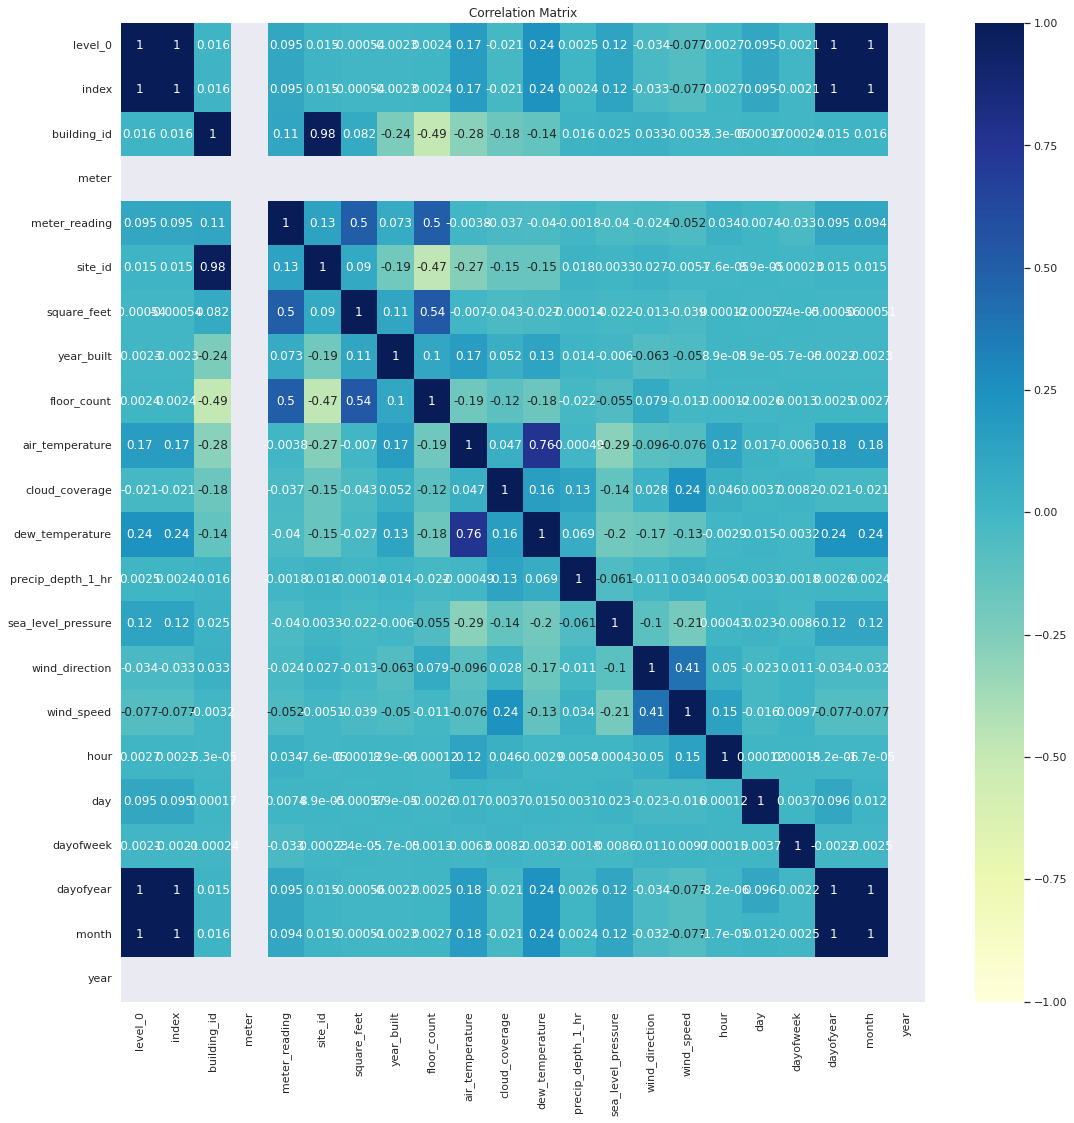

In [70]:
plt.figure(figsize=(18,18))
sns.heatmap(correlation_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()
# Since we only keep meter==0 which represents electricity

In [71]:
target_corr_df = pd.DataFrame(correlation_matrix["meter_reading"].sort_values(ascending=False))
target_corr_df 

,meter_reading
meter_reading,1.000000
square_feet,0.502454
floor_count,0.500677
site_id,0.134981
building_id,0.113688
index,0.094635
level_0,0.094624
dayofyear,0.094562
month,0.094351
year_built,0.073019


1. Site Id is extremely correlated with the Building Id (Correlation of 0.98).
2. Drew Tempreture and Air Tempreture have the second highest correlation, with a correlation of 0.76.
3. No features have a strong correlation with the target value 'Meter Reading'.

## Visualizing Features Histograms

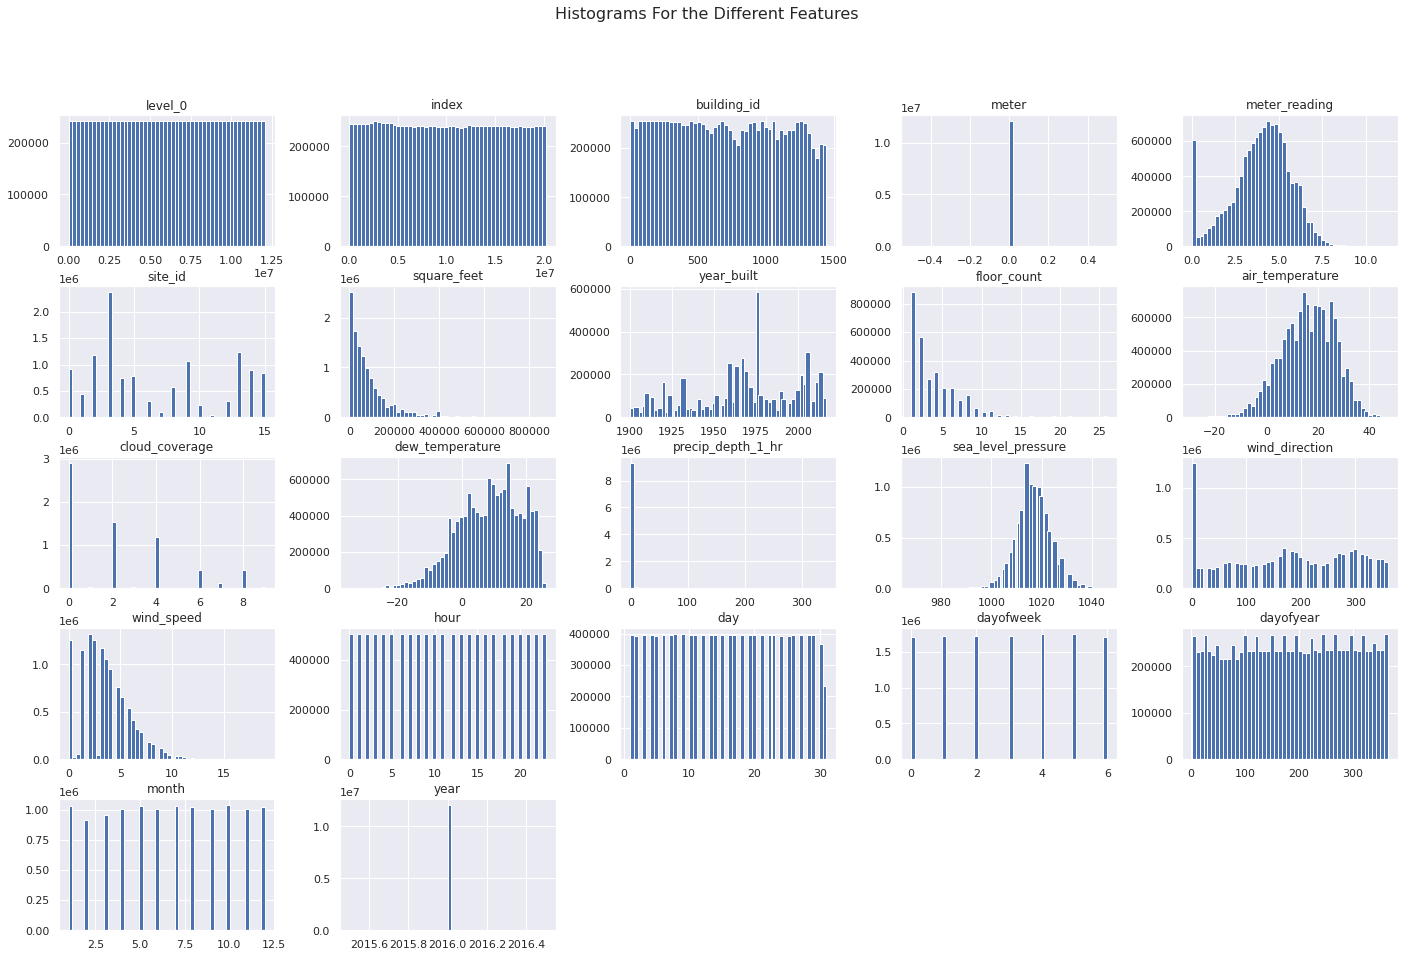

In [72]:
train.hist(bins=50, figsize=(24,15))
plt.suptitle('Histograms For the Different Features', fontsize=16)
plt.show()

Square Feet is heavily skewed to the left, therefore, we need to apply log transformation to fix that.

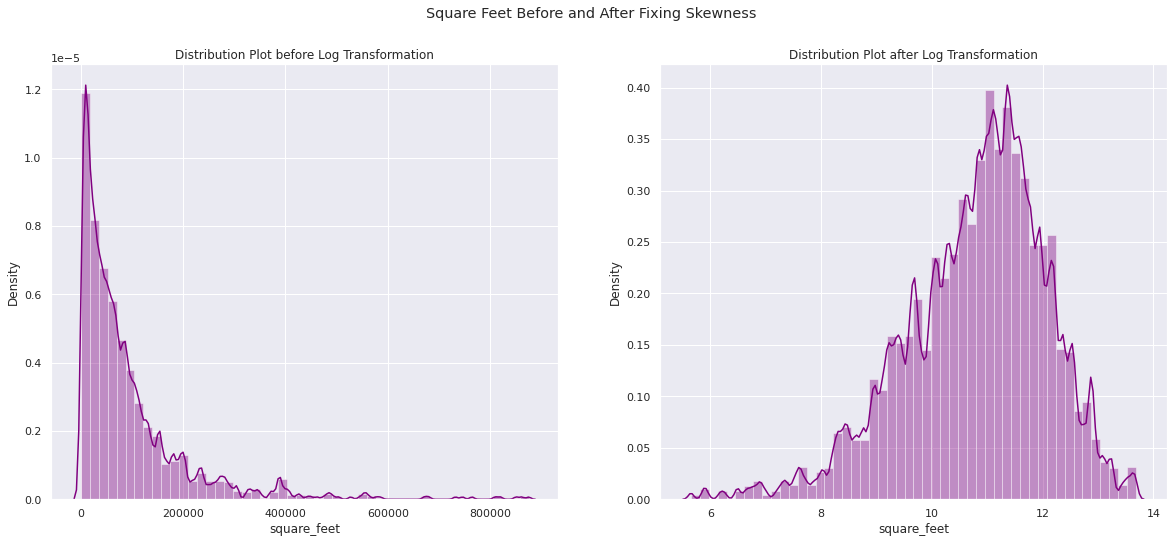

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Square Feet Before and After Fixing Skewness')

sns.distplot(train['square_feet'], color='purple', ax = ax1)
ax1.set_title('Distribution Plot before Log Transformation')

sns.distplot(np.log1p(train['square_feet']), color='purple', ax = ax2)
ax2.set_title('Distribution Plot after Log Transformation')

plt.show()

In [74]:
print('Square Feet skewness before Log Transformation is: ', train['square_feet'].skew())

train['square_feet'] = np.log1p(train['square_feet'])
print('Square Feet skewness after Log Transformation is: ', train['square_feet'].skew())

Square Feet skewness before Log Transformation is:  2.938759134115521
Square Feet skewness after Log Transformation is:  -0.6620225814877384
